In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

In [ ]:
confermed_df = pd.read_csv("confermed.csv")
deaths_df =  pd.read_csv("deaths.csv")
recovered_df = pd.read_csv("recovered.csv")
cases_country_df = pd.read_csv("cases_country.csv")

In [ ]:
confermed_df


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,30451,30616,30967,31238,31517,31836,32022,32324,32672,32951,33190,33384,33594,33908,34194,34366,34451,34455,34740,34994,35070,35229,35301,35475,35526,35615,35727,35928,35981,36036,36157,36263,36368,36471,36542,36675,36710,36710,36747,36782
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2269,2330,2402,2466,2535,2580,2662,2752,2819,2893,2964,3038,3106,3188,3278,3371,3454,3571,3667,3752,3851,3906,4008,4090,4171,4290,4358,4466,4570,4637,4763,4880,4997,5105,5197,5276,5396,5519,5620,5750
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,12685,12968,13273,13571,13907,14272,14657,15070,15500,15941,16404,16879,17348,17808,18242,18712,19195,19689,20216,20770,21355,21948,22549,23084,23691,24278,24872,25484,26159,26764,27357,27973,28615,29229,29831,30394,30950,31465,31972,32504
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,858,861,862,877,880,880,880,884,884,889,889,897,897,897,907,907,918,922,925,925,925,937,939
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,212,259,267,276,284,291,315,328,346,346,346,386,386,396,458,462,506,525,541,576,607,638,687,705,749,779,812,851,880,916,932,950,1000,1078,1109,1148,1164,1199,1280,1344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186400,6.613100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,712,713,713,713,714,715,717,719,719,720,721,724,724,726,727,727,729,732,732,737,740,741,743,746,746,746,747,749,860,862,863,865,867,868,870,871,874,874,874,875
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1089,1103,1118,1128,1158,1190,1221,1240,1248,1265,1284,1297,1318,1356,1380,1389,1465,1498,1516,1526,1552,1576,1581,1606,1619,1629,1640,1654,1674,1674,1681,1691,1703,1711,1726,1728,1730,1734,1734,1760
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,272,272,272,272,303,303,303,309,309,311,311,311,313,314,314,317,317,317,321,321,328,328,328,334,334,337,337,340,340,340,354,354,354,378,378,378,386,386,386,388
264,NaN,Tajikistan,38.861000,71.276100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5747,5799,5849,5900,5900,6005,6058,6058,6159,6213,6262,6315,6364,6410,6457,6506,6552,6596,6643,6695,6741,6786,6834,6878,6921,6967,7015,7060,7104,7150,7192,7235,7276,7320,7366,7409,7451,7495,7538,7583


In [ ]:
print(confermed_df.shape)
print(deaths_df.shape)
print(recovered_df.shape)
print(cases_country_df.shape)

(266, 200)
(266, 200)
(253, 200)
(188, 14)


In [ ]:
confermed_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '7/26/20', '7/27/20', '7/28/20', '7/29/20', '7/30/20', '7/31/20',
       '8/1/20', '8/2/20', '8/3/20', '8/4/20'],
      dtype='object', length=200)

In [ ]:
STARTE_DATE = {
    'Morocco': '4/2/20'
}
class Learner(object):
  def __init__(self, country , loss, start_date = '3/26/20', predict_range = 150, s_0 = 20000, i_0 = 3, r_0 = 10):
    self.country = country
    self.loss = loss
    self.start_date = start_date
    self.predict_range = predict_range
    self.s_0 = s_0
    self.i_0 = i_0
    self.r_0 = r_0   
  def load_confirmed(self, country):
    df = pd.read_csv("confermed.csv")
    df = df.drop(['Province/State'], axis = 1)
    country_df = df[df['Country/Region'] == country]
    return country_df.iloc[0].loc[self.start_date:]
  def load_recovered(self, country):
    df = pd.read_csv("recovered.csv")
    df = df.drop(['Province/State'], axis = 1)
    country_df = df[df['Country/Region'] == country]
    return country_df.iloc[0].loc[self.start_date:]
  def load_dead(self, country):
    df = pd.read_csv("deaths.csv")
    df = df.drop(['Province/State'], axis = 1)
    country_df = df[df['Country/Region'] == country]
    return country_df.iloc[0].loc[self.start_date:]
  def extend_index(self, index, new_size):
    values  = index.values
    current = datetime.strptime(index[-1], '%m/%d/%y')
    while len(values)< new_size:
      current = current + timedelta(days = 1)
      values = np.append(values, datetime.strftime(current, '%m/%/d%/y'))
    return values
  def predict(self, beta, gamma, data, recovered, deaths, country, s_0, i_0, r_0):
    new_index = self.extend_index(data.index, self.predict_range)
    size = len(new_index)
    def SIR(t,y):
      S = y[0]
      I = y[1]
      R = y[2]
      return [-beta*S*I, beta*S*I-gamma*I, gamma * I]
    extended_actual = np.concatenate((data.values, [None] * (size -len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size -len(recovered.values))))
    extended_deaths = np.concatenate((deaths.values, [None] * (size -len(deaths.values))))
    return new_index, extended_actual, extended_recovered, extended_deaths, solve_ivp(SIR, [0, size], [s_0, i_0, r_0], t_eval = np.arange(0, size, 1) )
  def train(self):
    recovered = self.load_recovered (self.country)
    death  =  self.load_dead (self.country)
    data =  (self.load_confirmed(self.country) - recovered - death) 
    optimal = minimize(loss, [0.001, 0.001], args = (data, recovered, self.s_0, self.i_0, self.r_0), method = 'L-BFGS-B', bounds =[(0.00000001, 0.4), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, extended_deaths, prediction = self.predict(beta, gamma, data, recovered, death, self.country, self.s_0, self.i_0, self.r_0)
    df = pd.DataFrame({'Infected data':extended_actual, 'recovered data' : extended_recovered, 'Death data': extended_deaths, 'Sucseptible': prediction.y[0], 'Infected':prediction.y[1],
                      'Recovered': prediction.y[2]}, index = new_index)
    df.to_csv(f"{self.country}.csv")
    fig, ax = plt.subplots(figsize = (15, 10))
    ax.set_title(self.country)
    df.plot(ax = ax)
    print(f"country = {self.country}, beta = {beta: .8f}, gamma = {gamma: .8f}, r_0: {(beta/gamma):.8f}")
    #fig.savefig(f"{slef.country}".png)
    return df, fig



In [ ]:
def loss(point, data, recovered, s_0, i_0, r_0):
  size = len(data)
  beta, gamma = point
  def SIR(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    return [-beta*S*I, beta*S*I-gamma*I, gamma * I]
  solution = solve_ivp(SIR, [0, size], [s_0, i_0, r_0], t_eval= np.arange(0, size, 1), vectorized= True)
  l1 = np.sqrt(np.mean((solution.y[1]-data)**2))
  l2 = np.sqrt(np.mean((solution.y[2]-recovered)**2))
  alpha = 0.01
  return alpha * l1 +(1- alpha) * l2 

In [ ]:
Morocco_Learner = Learner(country = "Morocco", loss = loss, i_0 = 3)

      fun: 1428.9553848796113
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.10013666e+05, 1.50458254e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 366
      nit: 28
   status: 0
  success: True
        x: array([1.07928916e-05, 1.63394737e-02])
country = Morocco, beta =  0.00001079, gamma =  0.01633947, r_0: 0.00066054


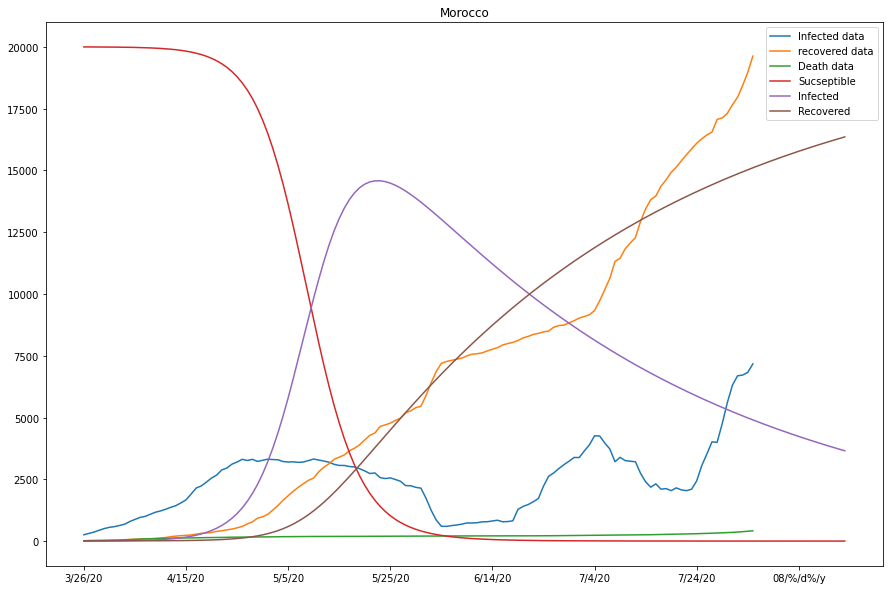

In [ ]:
Morocco_sir, morroco_fig =  Morocco_Learner.train() 

Prediction of corona virus in Morocco

In [ ]:
#Morocco_sir_df = pd.read_csv("dd.csv")

In [ ]:
#Morocco_sir_df.columns

In [ ]:
#Morocco_sir_df

In [ ]:
Morocco_sir = Morocco_sir[:200]
Morocco_sir.tail()

,Infected data,recovered data,Death data,Sucseptible,Infected,Recovered
08/%/d%/y,None,None,None,0.479992,3902.003923,16110.516085
08/%/d%/y,None,None,None,0.460373,3838.784974,16173.754654
08/%/d%/y,None,None,None,0.441850,3776.589505,16235.968646
08/%/d%/y,None,None,None,0.424349,3715.400969,16297.174682
08/%/d%/y,None,None,None,0.407803,3655.203086,16357.389111


In [ ]:
color_arr = px.colors.qualitative.Dark24

In [ ]:
def plot_sir_prediction(title, df_sir, remove_series=[], yaxis_type = "" ,yaxis_title = ""):
  fig = go.Figure()
  title = title
  labels = ['Infected data', 'recovered data', 'Death data', 'Sucseptible','Infected', 'Recovered']
  colors = [color_arr[0],color_arr[8],color_arr[2],color_arr[3],color_arr[7], color_arr[16]]
  line_size = [2,2,2,2,2,2]
  for index, data_series in enumerate(labels):
    if data_series not in remove_series:
      fig.add_trace(go.Scatter(x = df_sir.index, 
                               y = df_sir[data_series],
                               name = labels[index],
                               line = dict(
                                  color = colors[index],
                                  width = line_size[index]),
                               connectgaps=True,))
  xaxis = dict(
     title = "Date",
     showline = True,
     showgrid = True,
     showticklabels = True,
     linecolor = 'rgb(204, 204, 204)',
     linewidth = 2,
     ticks = 'outside',
     tickangle = 400,
     tickfont = dict(
         family = 'Arial',
         size = 10,
         color = 'rgb(82, 82, 82)',),)
  yaxis = dict(
     title = "case count",
     showline = True,
     showgrid = True,
     showticklabels = True,
     linecolor = 'rgb(204, 204, 204)',
     linewidth = 2,)
  if yaxis_type != "":
    yaxis['type'] = yaxis_type
  if yaxis_title != "":
    yaxis['title'] = yaxis_title
  fig.update_layout(
      xaxis = xaxis,
      yaxis = yaxis,
      autosize = True,
      margin = dict(autoexpand = True, l = 10, r = 10, t = 110,),
      showlegend = True)
  annotations = []
  annotations.append(dict(xref = 'paper', yref = 'paper', x = 0.0, y = 1.05,
                         xanchor = 'left', yanchor = 'bottom',
                         text = title,
                         font = dict(
                         family = 'Arial',
                         size = 16,
                         color = 'rgb(37, 37, 37)'),
                         showarrow = False))
                         
  fig.update_layout(annotations = annotations)
  return fig

In [ ]:
fig_1 = plot_sir_prediction(title = 'SIR__MODEL__PREDICTION__MOROCCO', df_sir = Morocco_sir)
fig_1.show()


In [ ]:
fig_1 = plot_sir_prediction(title = 'SIR__MODEL__PREDICTION__MOROCCO',
                            df_sir = Morocco_sir,
                            remove_series = ['Sucseptible'])
fig_1.show()

In [ ]:
fig2 = plot_sir_prediction(
    title = 'SIR__MODEL__PREDICTION__MOROCCO',
    df_sir = Morocco_sir,
    remove_series = ['Sucseptible'],
    yaxis_type = 'log',
    yaxis_title = 'case count'
)
fig2.show()